In [1]:
# --- Standard libraries
import pickle as pkl
import numpy as np
# --- PyTorch
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
# --- NetworkX
import networkx as nx
# --- RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# --- Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# --- Modules from local files
from GNN.GNN_atom import GNN, GNN_node
from dataset import XASDataset_atom
from utils.model import train_model, val_test
from utils.utils import plot_learning_curve

#### Load dataset

In [2]:
# --- Path raw directory containing the data
path = "./"
# --- Load and create the dataset
dataset = XASDataset_atom(path)

In [3]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[31]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

torch.save(dataset, './datasets/atom_dataset_long_7895.pt')

XASDataset_atom(7895)
------------
Number of graphs: 7895
Number of features: 15
Number of classes: 0

Data(x=[29, 15], edge_index=[2, 74], edge_attr=[74, 3], spectrum=[200], pos=[29, 3], z=[29], idx=[1], atom_num=[1], smiles='C12=[C:20]3[C:16]45[C:12]6([C:8]7=[C:10]8[C:9]([H:39])([H:40])[C:7]([H:30])=[C:6]([C:4]17[O:28][H:34])[C:5]([H:42])([H:43])[C:3]([H:41])=[C:2]2[C:1]1([H:29])[C:23]([H:35])([C:22]3([H:44])[C:21](=[O:25])[C:19]([H:37])([H:38])[C:18]4=[C:17]([H:32])[C:15]([H:31])=[C:14]6[C:13]([O:24][H:33])=[C:11]8[H:36])[O:26]1)[O:27]5')
------------
Number of nodes: 29
Number of edges: 74
Average node degree: 2.55
Has isolated nodes: False
Has self loops: False
Is undirected: True


#### View data

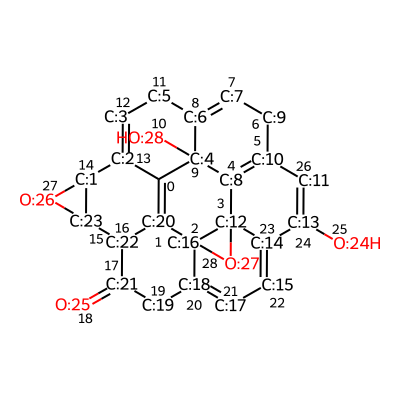

In [4]:
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
mol = Chem.MolFromSmiles(data.smiles)
mol

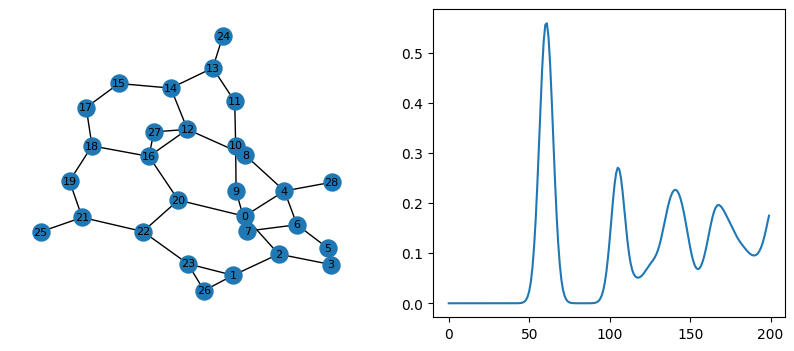

In [5]:
# --- Create subplot for 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)
nx.draw(mol_graph, ax=ax1, with_labels=True, node_size=150, font_size=8)

# --- Show an atomic spectrum from molecule
ax2.plot(data.spectrum)
plt.show()

#### Set up dataset for model

In [6]:
# --- Split into test, validation and test
train_dataset = dataset[:6000]
val_dataset = dataset[6001:6999]
test_dataset = dataset[7000:7895]

# train_dataset = dataset[:238]
# val_dataset = dataset[239:268]
# test_dataset = dataset[269:]

# --- Pass into dataloader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f'Length of training data loader: {len(train_loader.dataset)}, with a total of {len(train_loader)} datasets')
print(f'Length of validation data loader: {len(val_loader.dataset)}, with a total of {len(val_loader)} datasets')
print(f'Length of testing data loader: {len(test_loader.dataset)}, with a total of {len(test_loader)} datasets')

torch.save(test_dataset, './datasets/atom_test_dataset_long_7895.pt')

Length of training data loader: 6000, with a total of 47 datasets
Length of validation data loader: 998, with a total of 16 datasets
Length of testing data loader: 895, with a total of 14 datasets


#### Set up neural network

In [7]:
num_tasks = 200
num_layers = 3
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 64, 128]
out_channels = [64, 128, 256]
gnn_type = 'gcn'
heads = 1
drop_ratio = 0.5
graph_pooling = 'mean'

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)
print('----')
print(f'Training will be performed on: {device}')

GNN(
  (convs): ModuleList(
    (0): GCNConv(15, 64)
    (1): GCNConv(64, 128)
    (2): GCNConv(128, 256)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp): Linear(in_features=256, out_features=200, bias=True)
)
----
Training will be performed on: cuda


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, min_lr=0.000001)

#### Training the neural network

In [10]:
num_epochs = 1
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, device)

    val_loss = val_test(model, val_loader, device)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']

    if epoch%25 == 0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:5f}, TrainLoss: {train_loss:.7f}, ValLoss: {val_loss:7f}')

print('--------------')
print(f'Final training loss value of: {train_loss:.5f} and validation loss of: {val_loss:.5f}')

torch.float32 torch.float32
tensor(0.3070, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.float32 torch.float32
tensor(0.2479, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.float32 torch.float32
tensor(0.2165, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.float32 torch.float32
tensor(0.1536, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.float32 torch.float32
tensor(0.1543, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.float32 torch.float32
tensor(0.1429, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.float32 torch.float32
tensor(0.1252, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.float32 torch.float32
tensor(0.1063, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.float32 torch.float32
tensor(0.0893, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.float32 torch.float32
tensor(0.0831, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.float32 torch.float32
tensor(0.0664, device='cuda:0', grad_fn=<MseLossBackward0>)
torch.float32 torch.float32
tens

In [11]:
model_name = 'model_gnn_atom_test.pt'
torch.save(model.state_dict(), 'ML_models/' + model_name)

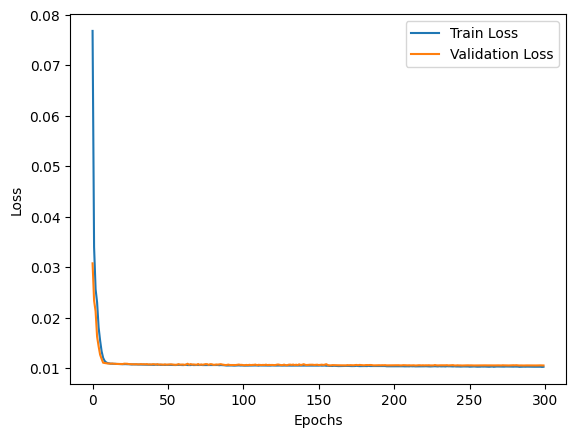

In [12]:
plot_learning_curve(num_epochs, train_losses, val_losses)

In [ ]:
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(15, 64)
        self.lin1 = torch.nn.Linear(15, 64)
        self.conv2 = GCNConv(64, 128)
        self.lin2 = torch.nn.Linear(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.lin3 = torch.nn.Linear(128, 256)
        self.conv4 = GCNConv(256, 200)
        self.lin4 = torch.nn.Linear(256, 200)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.relu(self.conv2(x, edge_index) + self.lin2(x))
        x = F.relu(self.conv3(x, edge_index) + self.lin3(x))
        x = self.conv4(x, edge_index) + self.lin4(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
loss_op = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, min_lr=0.000001)

print(model)
print(device)

Net(
  (conv1): GCNConv(15, 64)
  (lin1): Linear(in_features=15, out_features=64, bias=True)
  (conv2): GCNConv(64, 128)
  (lin2): Linear(in_features=64, out_features=128, bias=True)
  (conv3): GCNConv(128, 256)
  (lin3): Linear(in_features=128, out_features=256, bias=True)
  (conv4): GCNConv(256, 200)
  (lin4): Linear(in_features=256, out_features=200, bias=True)
)
cuda


In [ ]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # pred = model(data.x, data.edge_index)
        # loop_loss = 0
        # for x in range(len(data)):
        #     temp_loss = loss_op(pred[x], data.y[x])
        #     loop_loss += temp_loss
        
        # loss = loop_loss / len(data)
        # print(loss)

        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)

In [ ]:
@torch.no_grad()
def test(loader):
    model.eval()

    total_loss = 0
    for data in loader:
        data = data.to(device)

        # out = model(data.x, data.edge_index)
        # #print('out', out.shape)
        # #print('y', data.y[0].shape)

        # test = loss_op(out[0], data.y[0])
        # print(test)


        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader.dataset)

In [ ]:
import time

num_epochs = 500

times = []
for epoch in range(num_epochs):
    start = time.time()
    loss = train()
    val_f1 = test(val_loader)
    scheduler.step(val_f1)
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch: {epoch:03d}, LR: {current_lr:.3f}, Loss: {loss:.4f}, Val: {val_f1:.4f}')
    times.append(time.time() - start)

Epoch: 000, LR: 0.010, Loss: 0.0112, Val: 0.0100
Epoch: 001, LR: 0.010, Loss: 0.0097, Val: 0.0097
Epoch: 002, LR: 0.010, Loss: 0.0094, Val: 0.0092
Epoch: 003, LR: 0.010, Loss: 0.0091, Val: 0.0092
Epoch: 004, LR: 0.010, Loss: 0.0091, Val: 0.0090
Epoch: 005, LR: 0.010, Loss: 0.0088, Val: 0.0089
Epoch: 006, LR: 0.010, Loss: 0.0088, Val: 0.0090
Epoch: 007, LR: 0.010, Loss: 0.0087, Val: 0.0086
Epoch: 008, LR: 0.010, Loss: 0.0085, Val: 0.0085
Epoch: 009, LR: 0.010, Loss: 0.0085, Val: 0.0089
Epoch: 010, LR: 0.010, Loss: 0.0083, Val: 0.0082
Epoch: 011, LR: 0.010, Loss: 0.0083, Val: 0.0082
Epoch: 012, LR: 0.010, Loss: 0.0082, Val: 0.0084
Epoch: 013, LR: 0.010, Loss: 0.0082, Val: 0.0083
Epoch: 014, LR: 0.010, Loss: 0.0081, Val: 0.0082
Epoch: 015, LR: 0.010, Loss: 0.0081, Val: 0.0080
Epoch: 016, LR: 0.010, Loss: 0.0081, Val: 0.0083
Epoch: 017, LR: 0.010, Loss: 0.0080, Val: 0.0082
Epoch: 018, LR: 0.010, Loss: 0.0081, Val: 0.0085
Epoch: 019, LR: 0.010, Loss: 0.0081, Val: 0.0080
Epoch: 020, LR: 0.01

In [ ]:
model_name = 'model_test.pt'
torch.save(model.state_dict(), model_name)

In [ ]:
model.load_state_dict(torch.load(model_name, map_location='cpu'))

<All keys matched successfully>

In [ ]:
test_dataset[0]


Data(x=[30, 15], edge_index=[2, 76], edge_attr=[76, 3], y=[30, 200], pos=[30, 3], z=[30], idx=[1], smiles='c12[c:2]3[c:1]([H:39])[c:23]([H:40])[c:22]4[c:20]1[C:16]15[C:12]6=[C:14]([C:13]([H:30])=[C:11]([H:42])[C:10]7([C:24](=[O:29])[H:35])[C:8]6([H:43])[C:4]26[C:6]([C:5]([O:25][H:33])=[C:3]3[H:38])([C:7]([H:36])=[C:9]7[H:37])[O:28]6)[C:15]([H:31])=[C:17]([H:32])[C:18]1([C:19]([H:41])=[C:21]4[O:26][H:34])[O:27]5')

In [ ]:
model.eval()

out = model(test_dataset[0].x.to(device), test_dataset[0].edge_index.to(device))

In [ ]:
out.shape

torch.Size([30, 200])

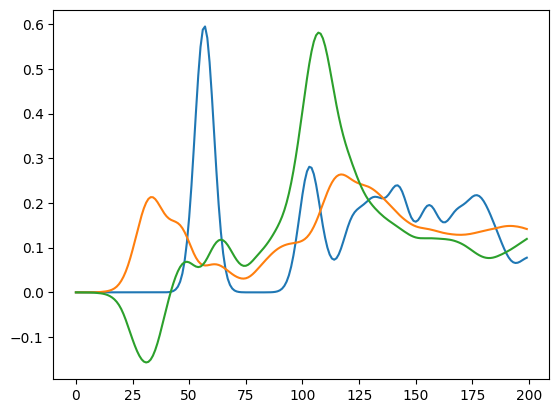

In [ ]:
plt.plot(test_dataset[0].y[5])
plt.plot(out[5].detach().cpu().numpy())
plt.plot(out[10].detach().cpu().numpy())
plt.show()